In [1]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range, input

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime

# carregando dados
import os
if not os.path.exists('user2movie.json') or \
   not os.path.exists('movie2user.json') or \
   not os.path.exists('usermovie2rating.json') or \
   not os.path.exists('usermovie2rating_test.json'):
   import preprocess2dict


with open('user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)


In [2]:
N = np.max(list(user2movie.keys())) + 1
# filmes dos dados de teste podem não estar nos dados de treino
# para garantir que isso nao aconteca vamos pegar o maior id de filme de ambas as bases
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

N: 10000 M: 2000


In [3]:
# inicializando variaveis
K = 10 # dimensionalidade latente
W = np.random.randn(N, K)#vetor de features de usuário
b = np.zeros(N)#bias usuários
U = np.random.randn(M, K)#vetor de features de filme
c = np.zeros(M)#bias item
mu = np.mean(list(usermovie2rating.values()))#media global

In [4]:
# prediction[i,j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

# medindo erro quadratico da previsao
def get_loss(d):
  # d: (user_id, movie_id) -> rating
  N = float(len(d))#numero de notas do dicionario
  sse = 0
  for k, r in d.items():
    i, j = k
    p = W[i].dot(U[j]) + b[i] + c[j] + mu #calculo da previsao
    sse += (p - r)*(p - r)#totalizando os erros quadraticos
  return sse / N #media do erro quadratico

In [5]:
epochs = 20
reg =0.01 # regularization penalty
train_losses = []
test_losses = []

#train the parameters


for epoch in range(epochs):
  print("epoch:", epoch)
  epoch_start = datetime.now()#medindo performance datetime
  # preenchendo as variaveis
    
  t0 = datetime.now()
  # preenchendo "W" e "b"
  # loop para cada usuario para calcualar W[i](vetor de 
  # features do usuário) e b[i](bias do usuário)
  for i in range(N):
    # for W
    matrix = np.eye(K) * reg #cria matriz vazia(1 nas diagonais 0 no resto) com a regularizacao de dimensionalidade "K"
    vector = np.zeros(K)# cria vetor em branco de dimensao "K"

    # for b
    bi = 0
    # para cada filme que o usuario viu atualiza valores em
    # matrix, vector e bi
    for j in user2movie[i]:
      r = usermovie2rating[(i,j)]# notas dos filmes do usuario
      matrix += np.outer(U[j], U[j])# produto externo do vetor de features do filme com ele mesmo
      vector += (r - b[i] - c[j] - mu)*U[j]# vetor de features do usuario
      bi += (r - W[i].dot(U[j]) - c[j] - mu)# bias das notas do usuario

    # set the updates
    W[i] = np.linalg.solve(matrix, vector)# vetor de feature de cada usuario
    b[i] = bi / (len(user2movie[i]) + reg)# bias de cada usuário

    if i % (N//10) == 0:
      print("i:", i, "N:", N)
  print("updated W and b:", datetime.now() - t0)

  # preenchendo "U" and "c"
    
  t0 = datetime.now()

  # loop para cada filme para calcualar W[i](vetor de 
  # features do item) e b[i](bias do item)
  for j in range(M):
    # for U
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for c
    cj = 0
    try:
      for i in movie2user[j]:
        r = usermovie2rating[(i,j)]# notas dos usuários para o filme
        matrix += np.outer(W[i], W[i])# produto externo do vetor de features do usuario com ele mesmo
        vector += (r - b[i] - c[j] - mu)*W[i]# vetor de features do filme
        cj += (r - W[i].dot(U[j]) - b[i] - mu)# bias das notas do filme

      # set the updates
      U[j] = np.linalg.solve(matrix, vector)# vetor de feature de cada filme
      c[j] = cj / (len(movie2user[j]) + reg)# bias de cada filme

      if j % (M//50) == 0:
        print("j:", j, "M:", M)
    except KeyError:
      # caso o filme não tenha nota
      pass
  print("updated U and c:", datetime.now() - t0)
  print("epoch duration:", datetime.now() - epoch_start)


  # armazenando erro quadratico do treino
  t0 = datetime.now()
  train_losses.append(get_loss(usermovie2rating))

  # armazenando erro quadratico do teste
  test_losses.append(get_loss(usermovie2rating_test))
  print("calculate cost:", datetime.now() - t0)
  print("train loss:", train_losses[-1])
  print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

epoch: 0
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:01:02.099051
j: 0 M: 2000
j: 40 M: 2000
j: 80 M: 2000
j: 120 M: 2000
j: 160 M: 2000
j: 200 M: 2000
j: 240 M: 2000
j: 280 M: 2000
j: 320 M: 2000
j: 360 M: 2000
j: 400 M: 2000
j: 440 M: 2000
j: 480 M: 2000
j: 520 M: 2000
j: 560 M: 2000
j: 600 M: 2000
j: 640 M: 2000
j: 680 M: 2000
j: 720 M: 2000
j: 760 M: 2000
j: 800 M: 2000
j: 840 M: 2000
j: 880 M: 2000
j: 920 M: 2000
j: 960 M: 2000
j: 1000 M: 2000
j: 1040 M: 2000
j: 1080 M: 2000
j: 1120 M: 2000
j: 1160 M: 2000
j: 1200 M: 2000
j: 1240 M: 2000
j: 1280 M: 2000
j: 1320 M: 2000
j: 1360 M: 2000
j: 1400 M: 2000
j: 1440 M: 2000
j: 1480 M: 2000
j: 1520 M: 2000
j: 1560 M: 2000
j: 1600 M: 2000
j: 1640 M: 2000
j: 1680 M: 2000
j: 1720 M: 2000
j: 1760 M: 2000
j: 1800 M: 2000
j: 1840 M: 2000
j: 1880 M: 2000
j: 1920 M: 2000
j: 1960 M: 2000
updated U and c: 0:01

j: 160 M: 2000
j: 200 M: 2000
j: 240 M: 2000
j: 280 M: 2000
j: 320 M: 2000
j: 360 M: 2000
j: 400 M: 2000
j: 440 M: 2000
j: 480 M: 2000
j: 520 M: 2000
j: 560 M: 2000
j: 600 M: 2000
j: 640 M: 2000
j: 680 M: 2000
j: 720 M: 2000
j: 760 M: 2000
j: 800 M: 2000
j: 840 M: 2000
j: 880 M: 2000
j: 920 M: 2000
j: 960 M: 2000
j: 1000 M: 2000
j: 1040 M: 2000
j: 1080 M: 2000
j: 1120 M: 2000
j: 1160 M: 2000
j: 1200 M: 2000
j: 1240 M: 2000
j: 1280 M: 2000
j: 1320 M: 2000
j: 1360 M: 2000
j: 1400 M: 2000
j: 1440 M: 2000
j: 1480 M: 2000
j: 1520 M: 2000
j: 1560 M: 2000
j: 1600 M: 2000
j: 1640 M: 2000
j: 1680 M: 2000
j: 1720 M: 2000
j: 1760 M: 2000
j: 1800 M: 2000
j: 1840 M: 2000
j: 1880 M: 2000
j: 1920 M: 2000
j: 1960 M: 2000
updated U and c: 0:00:58.826247
epoch duration: 0:01:57.843238
calculate cost: 0:00:13.115498
train loss: 0.5049662478902761
test loss: 0.5435615359213369
epoch: 8
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 70

j: 840 M: 2000
j: 880 M: 2000
j: 920 M: 2000
j: 960 M: 2000
j: 1000 M: 2000
j: 1040 M: 2000
j: 1080 M: 2000
j: 1120 M: 2000
j: 1160 M: 2000
j: 1200 M: 2000
j: 1240 M: 2000
j: 1280 M: 2000
j: 1320 M: 2000
j: 1360 M: 2000
j: 1400 M: 2000
j: 1440 M: 2000
j: 1480 M: 2000
j: 1520 M: 2000
j: 1560 M: 2000
j: 1600 M: 2000
j: 1640 M: 2000
j: 1680 M: 2000
j: 1720 M: 2000
j: 1760 M: 2000
j: 1800 M: 2000
j: 1840 M: 2000
j: 1880 M: 2000
j: 1920 M: 2000
j: 1960 M: 2000
updated U and c: 0:01:01.388029
epoch duration: 0:02:02.340714
calculate cost: 0:00:13.579713
train loss: 0.5035197162918476
test loss: 0.5422331455044282
epoch: 15
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:01:00.400845
j: 0 M: 2000
j: 40 M: 2000
j: 80 M: 2000
j: 120 M: 2000
j: 160 M: 2000
j: 200 M: 2000
j: 240 M: 2000
j: 280 M: 2000
j: 320 M: 2000
j: 360 M: 2000
j: 400 M: 2000
j: 440 M: 2000


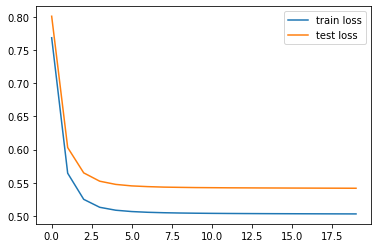

In [6]:
# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()